In [1]:
from bs4 import BeautifulSoup
import requests 
import pandas as pd
import numpy as np
import json 
import folium
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from geopy.geocoders import Nominatim #
from pandas.io.json import json_normalize
from sklearn.cluster import DBSCAN 
from sklearn.datasets.samples_generator import make_blobs 
%matplotlib inline

# collect and process data

## neighbourhood postcode and locations

In [2]:
# pass the HTML file 
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
r  = requests.get(url)
data = r.text
soup = BeautifulSoup(data, 'lxml')
# get table 
postcodetable = soup.table.text.split('\n')
# read table
postcode = postcodetable[2::5]
borough = postcodetable[3::5]
neighbourhood = postcodetable[4::5]
# create pandas structure 
# define the dataframe columns
column_names = [postcode[0], borough[0], neighbourhood[0]] 

# instantiate the dataframe
postcodes = pd.DataFrame(columns=column_names)

# instantiate the data 
for i in range(len(postcode)-1):
    
# ignore 'not assigned' data
    if borough[i+1] != 'Not assigned':
        postcodes = postcodes.append({'Postcode':postcode[i+1],'Borough': borough[i+1],
                                          'Neighbourhood': neighbourhood[i+1]}, ignore_index=True)
# process data 

# concatenate same postcodes
postcodes = postcodes.groupby(['Postcode','Borough'], sort=False)['Neighbourhood'].apply(lambda x: ','.join(x)).reset_index()

# process 'not assigned' data
i_nan = np.where(postcodes['Neighbourhood']=='Not assigned')[0]
postcodes['Neighbourhood'][i_nan] = postcodes['Borough'][i_nan]

In [3]:
!wget -q -O 'toronto_data_1.json' http://cocl.us/Geospatial_data
print('Data downloaded!')

Data downloaded!


In [4]:
# readdata and build up structure 
with open('toronto_data.json') as json_data:
    a = json_data.read()
    
# create pandas structure 
# define the dataframe columns
column_names = a.split('\n')[0].split(',')

# instantiate the dataframe
positions = pd.DataFrame(columns=column_names)
positions = positions.rename(columns={"Postal Code": "Postcode"})

# instantiate the data 
for i in range(len(a.split('\n'))-1):
    positions = positions.append({'Postcode':a.split('\n')[i+1].split(',')[0],'Latitude': float(a.split('\n')[i+1].split(',')[1]),
                                          'Longitude':float(a.split('\n')[i+1].split(',')[2])}, ignore_index=True)

In [5]:
# merge position information and postcodes
toronto = pd.merge(postcodes, positions)

## population from Statistics Canada website

In [6]:
# get the data containing population and postcode
url = 'https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Tables/File.cfm?T=1201&SR=1&RPP=9999&PR=0&CMA=0&CSD=0&S=22&O=A&Lang=Eng&OFT=CSV'
r  = requests.get(url)
populationtable = r.text.split('\r\n')

In [7]:
# read data to a pandas data frame 
column_names = ['Postcode', 'Population']

population = pd.DataFrame(columns=column_names,dtype='float')

for i in range(len(populationtable)-2-12):
    readline = populationtable[i+2].split(',')
    population = population.append({'Postcode':readline[0][1:-1],'Population': int(readline[4]),
                                          }, ignore_index=True)

In [8]:
# merge population information and postcodes
toronto = toronto.join(population.set_index('Postcode'), on='Postcode')
toronto['Population']  = toronto['Population'].fillna(0).astype(int)

## get venue information in foursquare.com

In [9]:
# function getting nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
# create a new data frame toronto_venues 
limit = 100
radius = 500
toronto_data = toronto
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

In [16]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighbourhood').sum().reset_index()



In [17]:
toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_grouped.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged['Chinese Restaurant']  = toronto_merged['Chinese Restaurant'].fillna(0).astype(int)

In [18]:
toronto_merged['Venue number'] = toronto_merged.loc[:,'Accessories Store':'Yoga Studio'].sum(axis=1).fillna(0).astype(int)
#toronto = toronto.reset_index()

## fraction of Chinese immigration 

in https://en.wikipedia.org/wiki/Demographics_of_Toronto#Ethnic_diversity, we get to know that the percentage of Chinese Canadians are: 
<br>
Toronto & East York: 9.7%
<br>North York: 13.3%
<br>Scarborough: 19.0%
<br>Mississauga: 7.6%
<br>Etobicoke, York: less than 5.2%
<br>Queen's park: no information

In [19]:
toronto_merged['Chinese fraction'] = 0

In [20]:
toronto_merged['Chinese fraction'].iloc[np.where(toronto_merged['Borough'].str.contains('Toronto'))[0]] = 0.097
toronto_merged['Chinese fraction'].iloc[np.where(toronto_merged['Borough']=='East York')[0]] = 0.097
toronto_merged['Chinese fraction'].iloc[np.where(toronto_merged['Borough']=='North York')[0]] = 0.133
toronto_merged['Chinese fraction'].iloc[np.where(toronto_merged['Borough']=='Scarborough')[0]] = 0.019
toronto_merged['Chinese fraction'].iloc[np.where(toronto_merged['Borough']=='Mississauga')[0]] = 0.076
# we assume the following number
toronto_merged['Chinese fraction'].iloc[np.where(toronto_merged['Borough']=='Etobicoke')[0]] = 0.05
toronto_merged['Chinese fraction'].iloc[np.where(toronto_merged['Borough']=='York')[0]] = 0.05
toronto_merged['Chinese fraction'].iloc[np.where(toronto_merged['Borough']=="Queen's Park")[0]] = 0.03

toronto_merged['Chinese fraction'] = toronto_merged['Chinese fraction'].astype(float)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [21]:
toronto_merged['Chinese Population'] = 0
toronto_merged['Chinese Population'] = toronto_merged['Chinese fraction']*toronto_merged['Population']

In [23]:
toronto_merged.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,...,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Venue number,Chinese fraction,Chinese Population
0,M3A,North York,Parkwoods,43.753259,-79.329656,34615,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.133,4603.795
1,M4A,North York,Victoria Village,43.725882,-79.315572,14443,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0.133,1920.919
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,41078,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,46,0.097,3984.566
3,M6A,North York,"Lawrence Heights,Lawrence Manor",43.718518,-79.464763,21048,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2.0,0.0,13,0.133,2799.384
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,10,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,38,0.097,0.970


# explore the data

describe the Chinese restaurant data

In [82]:
toronto_merged['Chinese Restaurant'].describe()

count    103.000000
mean       0.223301
std        0.576195
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.000000
Name: Chinese Restaurant, dtype: float64

show their position on the map

In [25]:
address = 'Toronto, CA'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [26]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors
map_chineserestaurant = folium.Map(location=[latitude, longitude], zoom_start=10)

xmax = int(toronto_merged['Chinese Restaurant'].max())
# set color scheme for the clusters
x = np.arange(xmax)
ys = [i + x + (i*x)**2 for i in range(xmax)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, nums in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Chinese Restaurant']):
    label = folium.Popup(str(nums)+ 'Chinese Restaurants in ' +str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(nums)-1],
        fill=True,
        fill_color=rainbow[int(nums)-1],
        fill_opacity=0.7).add_to(map_chineserestaurant)
       
map_chineserestaurant

We noticed that the density of the neighbourhoods has obvious difference and could be divided into two parts, so we must divide this city into two parts: 

* City of Toronto 

* Other Neighbourhoods 

To do this, we add another index 'Toronto city', 1 indicate in city of Toronto, and 0 indicate other neighbourhoods. 

I used a method of DBSCAN clustering (density based clustering method)

In [27]:
# set up and run the model 
epsilon = 0.015
minimumSamples = 4
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(toronto_merged[['Latitude','Longitude']])

n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_clusters_

1

In [28]:
toronto_merged['Toronto city'] = db.labels_+1

In [29]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

xmax = int(toronto_merged['Chinese Restaurant'].max())
# set color scheme for the clusters
x = np.arange(xmax)
ys = [i + x + (i*x)**2 for i in range(xmax)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, nums in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Toronto city']):
    label = folium.Popup(str(nums)+ 'Chinese Restaurants in ' +str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(nums)-1],
        fill=True,
        fill_color=rainbow[int(nums)-1],
        fill_opacity=0.7).add_to(map_toronto)
       
map_toronto

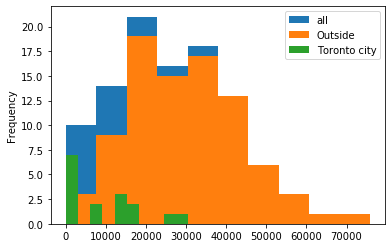

In [30]:
# show population in each group
toronto_merged['Population'].plot.hist(label='all')
i_city = np.where(toronto_merged['Toronto city']==0)[0]
toronto_merged['Population'][i_city].plot.hist(label='Outside')
i_city = np.where(toronto_merged['Toronto city']==1)[0]
toronto_merged['Population'][i_city].plot.hist(label='Toronto city')
plt.legend()

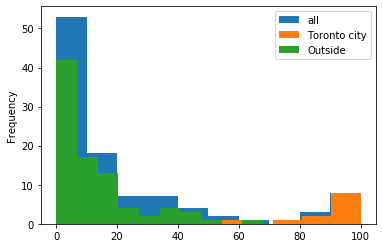

In [31]:
# show venue numbers in each group 
toronto_merged['Venue number'].plot.hist(label='all')
i_city = np.where(toronto_merged['Toronto city']==1)[0]
toronto_merged['Venue number'][i_city].plot.hist(label='Toronto city')
i_city = np.where(toronto_merged['Toronto city']==0)[0]
toronto_merged['Venue number'][i_city].plot.hist(label='Outside')
plt.legend()

* Inside of city of Toronto, neighbourhood density is large, and venue number is always high, but people usually doesn't live there 

* Outside of the city of Toronto, neighbourhood is sparse, there isn't much venues, and people tend to live there. 

## assumption 1: the number of Chinese restaurant is related to population and venue numbers

We first assume that the number of chinese restaurant is related to population or population of Chinese immigrations. We test the correlation between these different variables and the number of Chinese Restaurant 

Chinese Restaurant    1.000000
Population           -0.015055
Chinese fraction     -0.045457
Chinese Population   -0.064093
Venue number          0.363665
Name: Chinese Restaurant, dtype: float64

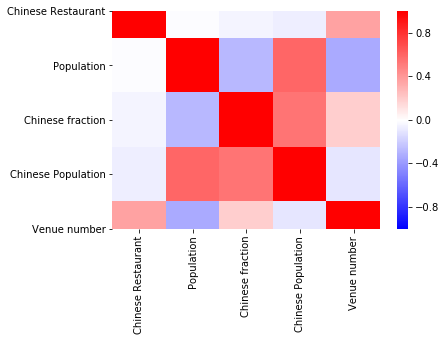

In [32]:
corr = toronto_merged[['Chinese Restaurant','Population','Chinese fraction','Chinese Population','Venue number']].corr()
sns.heatmap(corr,vmax=1,vmin=-1,cmap='bwr')
corr['Chinese Restaurant']

#### in Toronto city:

Chinese Restaurant    1.000000
Population            0.345365
Chinese fraction      0.000000
Chinese Population    0.345365
Venue number          0.071831
Name: Chinese Restaurant, dtype: float64


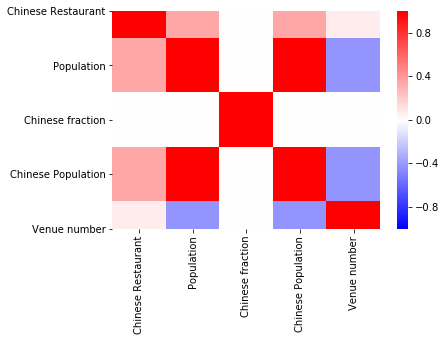

In [33]:
i_city = np.where(toronto_merged['Toronto city']==1)[0]
corr = toronto_merged[['Chinese Restaurant','Population','Chinese fraction','Chinese Population','Venue number']].iloc[i_city].corr()
sns.heatmap(corr,vmax=1,vmin=-1,cmap='bwr')
print (corr['Chinese Restaurant'])


In the looking up table, 95% significant value for the correlation when n-2 = 14 is ***0.67***. So the number of Chinese restaurant is not related to any factors inside city of Toronto. 

Chinese Restaurant    1.000000
Population            0.174136
Chinese fraction     -0.156289
Chinese Population   -0.030492
Venue number          0.258348
Name: Chinese Restaurant, dtype: float64


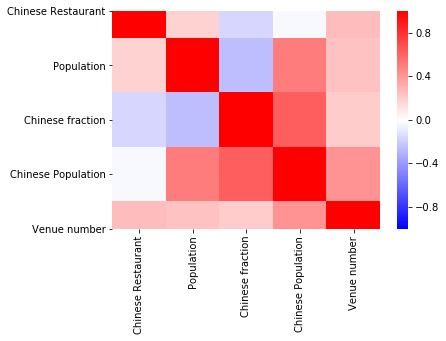

In [34]:
i_city = np.where(toronto_merged['Toronto city']==0)[0]
corr = toronto_merged[['Chinese Restaurant','Population','Chinese fraction','Chinese Population','Venue number']].iloc[i_city].corr()
print (corr['Chinese Restaurant'])
sns.heatmap(corr,vmax=1,vmin=-1,cmap='bwr')

In the looking up table, 95% significant value for the correlation when n-2 = 87 is ***0.22***. So venue number is correlated with the number of chinese restaurants. 

***Conclustions:***

1. Outside of the city, the number of Chinese Restaurant is correlated to venue number 

2. Inside of city of Toronto, population is an important factor, while it is not statistically significant. 

## assumption 2: the number of Chinese restaurant is related to the number of other venues

In [35]:
toronto_group = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_group.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide,King,Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,...,0.0,0.02,0.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0
4,"Alderwood,Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0


In [36]:
toronto_group.corr()['Chinese Restaurant'].sort_values(ascending=False)

Chinese Restaurant        1.000000
Department Store          0.365572
Thrift / Vintage Store    0.349942
Japanese Restaurant       0.340257
Bank                      0.308159
                            ...   
Restaurant               -0.079571
Steakhouse               -0.081283
Liquor Store             -0.085537
Bakery                   -0.086811
Park                     -0.143643
Name: Chinese Restaurant, Length: 267, dtype: float64

In the looking up table, 95% significant value for the correlation when n-2 = 101 is ***0.195***. In another word, if the correlation coefficient is higher than 0.195, it means this venue is very likely to appear simultaneously with Chinese Restaurant. 

In [37]:
toronto_group.corr()['Chinese Restaurant'].iloc[np.where(toronto_group.corr()['Chinese Restaurant']>0.197)]

Bank                      0.308159
Café                      0.197182
Chinese Restaurant        1.000000
Department Store          0.365572
Discount Store            0.272427
Gaming Cafe               0.301129
Indian Restaurant         0.233137
Japanese Restaurant       0.340257
Thrift / Vintage Store    0.349942
Vietnamese Restaurant     0.198470
Name: Chinese Restaurant, dtype: float64



These venues listed occurs simultaneously with Chinese Restaurant. 

We can use the K_means cluster method to divide the neighbourhoods into different clusters. And choose those cluster that contains these venues related to Chinese Restaurant. 

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [39]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_group['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_group.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Thai Restaurant,Steakhouse,Café,Restaurant,Burger Joint,Bakery,Sushi Restaurant,Bar,Cosmetics Shop
1,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Clothing Store,Breakfast Spot,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Park,Playground,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Pizza Place,Grocery Store,Liquor Store,Discount Store,Fried Chicken Joint,Japanese Restaurant,Sandwich Place,Beer Store,Fast Food Restaurant,Pharmacy
4,"Alderwood,Long Branch",Pizza Place,Pub,Pharmacy,Sandwich Place,Dance Studio,Pool,Skating Rink,Coffee Shop,Gym,Comfort Food Restaurant


In [40]:
# set number of clusters
kclusters = 6

toronto_grouped_clustering = toronto_group.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 3, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [41]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_clustered = toronto_data.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_clustered['Cluster Labels']  = toronto_clustered['Cluster Labels'].fillna(0).astype(int)
toronto_merged['Cluster Labels'] = toronto_clustered['Cluster Labels']
toronto_clustered.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,34615,3,Park,Bus Stop,Food & Drink Shop,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Falafel Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,14443,1,Hockey Arena,Portuguese Restaurant,Intersection,Coffee Shop,Pizza Place,Financial or Legal Service,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,41078,1,Coffee Shop,Park,Café,Pub,Bakery,Theater,Mexican Restaurant,Breakfast Spot,Yoga Studio,Hotel
3,M6A,North York,"Lawrence Heights,Lawrence Manor",43.718518,-79.464763,21048,1,Accessories Store,Clothing Store,Women's Store,Boutique,Sporting Goods Shop,Miscellaneous Shop,Furniture / Home Store,Event Space,Vietnamese Restaurant,Coffee Shop
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494,10,1,Coffee Shop,Park,Gym,Yoga Studio,Burrito Place,Fast Food Restaurant,Beer Bar,Italian Restaurant,Japanese Restaurant,Seafood Restaurant


Text(0, 0.5, 'Cluster number')

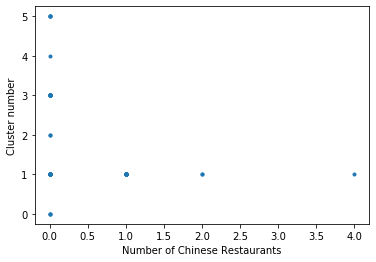

In [42]:
plt.plot(toronto_merged['Chinese Restaurant'].values,toronto_merged['Cluster Labels'].values,'.')
plt.xlabel('Number of Chinese Restaurants')
plt.ylabel('Cluster number')

All of the Chinese restaurant appears in cluster 1 neighbourhoods. 

In [43]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

xmax = int(toronto_merged['Cluster Labels'].max())
# set color scheme for the clusters
x = np.arange(xmax)
ys = [i + x + (i*x)**2 for i in range(xmax)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, nums in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(nums)+ 'Chinese Restaurants in ' +str(poi))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(nums)-1],
        fill=True,
        fill_color=rainbow[int(nums)-1],
        fill_opacity=0.7).add_to(map_toronto)
       
map_toronto

In [44]:
# show some statistics of cluster 1 outside of Toronto
i_city_cluster = np.where(np.all([toronto_merged['Toronto city'] == 0, toronto_merged['Cluster Labels']==1],axis=0))[0]
i_city = np.where(np.all([toronto_merged['Toronto city'] == 0],axis=0))[0]
print (len(i_city_cluster),len(i_city))
print (toronto_merged[['Venue number','Chinese Restaurant']].iloc[i_city_cluster].sum())
print (toronto_merged[['Venue number','Chinese Restaurant']].iloc[i_city_cluster].corr())


67 87
Venue number          1001
Chinese Restaurant      12
dtype: int64
                    Venue number  Chinese Restaurant
Venue number            1.000000            0.204579
Chinese Restaurant      0.204579            1.000000


In [45]:
# show some statistics of cluster 1 outside of Toronto
i_city_cluster = np.where(np.all([toronto_merged['Toronto city'] == 1, toronto_merged['Cluster Labels']==1],axis=0))[0]
i_city = np.where(np.all([toronto_merged['Toronto city'] == 1],axis=0))[0]
print (len(i_city_cluster),len(i_city))
print (toronto_merged[['Venue number','Chinese Restaurant']].iloc[i_city_cluster].sum())
print (toronto_merged[['Venue number','Chinese Restaurant']].iloc[i_city_cluster].corr())


15 16
Venue number          1194
Chinese Restaurant      11
dtype: int64
                    Venue number  Chinese Restaurant
Venue number            1.000000           -0.031498
Chinese Restaurant     -0.031498            1.000000


# build up the model 

So far, we use a DBSCAN model to divide the neighborhoods in Toronto into two parts: City of Toronto and outside the city of Toronto. We find out: 

* in the city of Toronto, neighborhoods are close to each other. Venue number is high and population is low, and the number of Chinese Restaurant is more related with population. 

* Outside of the city of Toronto, neighborhoods are separated. There lives more people while there are fewer venues. The number of Chinese Restaurants is correlated to venue numbers. 

* Chinese Restaurants are more likely to appear in cluster 1 in our K-means clustering result, which represents 'coffee shops and restaurants'. 

* Chinese Restaurants appears correlated to these venues:

    Bank                      
    Café                      
    Department Store         
    Discount Store            
    Gaming Cafe               
    Indian Restaurant         
    Japanese Restaurant       
    Thrift / Vintage Store    
    Vietnamese Restaurant    
 We regard these venues as targeted venues. 

* The number of Chinese restaurants are still very limited in Toronto. 

According to the analysis, we decide model separately according to in or outside of the Toronto city. 

1. We build up a content based recommendation system model. We regard all of the targeted venues as one kind, calculate the total number of the targeted venues, and then normalize it. 

2. We divide neighbourhoods into two groups: City of Toronto, and outside Toronto. In two groups, we only consider the neighbourhoods in cluster 1 in k-mean clustering. 

3. In the City of Toronto group, we also consider population and normalize it. In the outside of Toronto group, we also consider venue numbers and normalize it. Then we multiplies each index with the targeted venues index, and get the final index. 





In [63]:
# calculate the normalized targeted venue number
targeted_venues = toronto_merged[['Bank','Café','Department Store',\
                'Discount Store','Gaming Cafe','Indian Restaurant','Japanese Restaurant',\
                'Thrift / Vintage Store','Vietnamese Restaurant']].sum(axis=1)
targeted_venues = targeted_venues/targeted_venues.max()

In [64]:
# select cluster 1 outside Toronto
i_outside = np.where(np.all([toronto_merged['Toronto city'] == 0,\
                             toronto_merged['Cluster Labels']==1],axis=0))[0]

In [65]:
# select cluster 1 inside Toronto
i_inside = np.where(np.all([toronto_merged['Toronto city'] == 1, \
        toronto_merged['Cluster Labels']==1],axis=0))[0]

In [67]:
toronto_merged['index'] = 0
# calculate index representing venue numbers

toronto_merged['index'].iloc[i_outside] = (toronto_merged['Venue number'].iloc[i_outside]-
        toronto_merged['Venue number'].iloc[i_outside].min())/(toronto_merged['Venue number']\
                .iloc[i_outside].max()-toronto_merged['Venue number'].iloc[i_outside].min()) 
# calculate index representing population

toronto_merged['index'].iloc[i_inside] = (toronto_merged['Population'].iloc[i_inside]-
        toronto_merged['Population'].iloc[i_inside].min())/(toronto_merged['Population']\
                .iloc[i_inside].max()-toronto_merged['Population'].iloc[i_inside].min()) 

In [72]:
toronto_merged['index'] = toronto_merged['index']*targeted_venues

# model result
We recommend those ten neighborhoods:

In [73]:
toronto_predict = (toronto_merged[['Postcode','Borough','Neighbourhood','Latitude','Longitude','index']]).sort_values(by='index',ascending = False).head(10)
toronto_predict

,Postcode,Borough,Neighbourhood,Latitude,Longitude,index
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,0.727273
84,M5T,Downtown Toronto,"Chinatown,Grange Park,Kensington Market",43.653206,-79.400049,0.582436
33,M2J,North York,"Fairview,Henry Farm,Oriole",43.778517,-79.346556,0.363636
37,M6J,West Toronto,"Little Portugal,Trinity",43.647927,-79.419750,0.352782
36,M5J,Downtown Toronto,"Harbourfront East,Toronto Islands,Union Station",43.640816,-79.381752,0.347144
9,M5B,Downtown Toronto,"Ryerson,Garden District",43.657162,-79.378937,0.343281
80,M5S,Downtown Toronto,"Harbord,University of Toronto",43.662696,-79.400049,0.321022
74,M5R,Central Toronto,"The Annex,North Midtown,Yorkville",43.672710,-79.405678,0.316189
59,M2N,North York,Willowdale South,43.770120,-79.408493,0.276798
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0.276418


show their position on the map

In [81]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

xmax = int(toronto_predict['index'].max())
# set color scheme for the clusters
x = np.arange(3)
ys = [i + x + (i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, nums in zip(toronto_predict['Latitude'], toronto_predict['Longitude'], toronto_predict['Neighbourhood'], toronto_predict['index']):
    label = folium.Popup(str(nums)+ 'Chinese Restaurants in ' +str(poi))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[0],
        fill=True,
        fill_color=rainbow[0],
        fill_opacity=0.7).add_to(map_toronto)
       
map_toronto

Because our aim is to recommend data, we don't need to evaluate our model in this project. 